## Imports

In [233]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
from torch import nn # for Model building, loss functions, activation functions
from torch import optim
import torch.nn.functional as F # activations functions

from torchvision import datasets, transforms

## Auxliary plotting function

In [84]:
# https://discuss.pytorch.org/t/view-classify-in-module-helper/30279/6

def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# Load MNIST Dataset
First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [85]:
# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [86]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

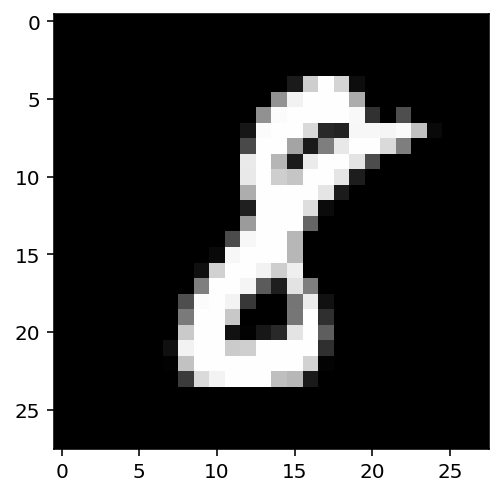

In [87]:
plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

<img src="assets/mlp_mnist.png" width=600px>

To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. Below are a few different commonly used activation functions.

<img src="assets/activation.png" width=700px>

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [88]:
class Network(nn.Module):
    
    # Defining the layers, 128, 64, 10 units each
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Sequential API
PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [89]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [128, 64]
output_size   = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


You can also pass in an `OrderedDict` to name the individual layers and operations. Note that a dictionary keys must be unique, so _each operation must have a different name_.

In [90]:
model = nn.Sequential(OrderedDict([
          ('fc1',   nn.Linear(input_size, hidden_sizes[0])),
          ('relu1', nn.ReLU()),
          ('fc2',   nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('relu2', nn.ReLU()),
          ('output', nn.Linear(hidden_sizes[1], output_size)),
          ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [91]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[-0.0186, -0.0037,  0.0014,  ...,  0.0003,  0.0281, -0.0234],
        [-0.0047,  0.0226,  0.0113,  ...,  0.0104, -0.0141, -0.0260],
        [-0.0065,  0.0289, -0.0284,  ...,  0.0166, -0.0006,  0.0308],
        ...,
        [ 0.0079,  0.0352, -0.0157,  ..., -0.0222, -0.0094, -0.0210],
        [ 0.0158,  0.0271,  0.0185,  ..., -0.0086, -0.0234,  0.0282],
        [ 0.0114,  0.0100,  0.0337,  ..., -0.0153,  0.0322,  0.0224]],
       requires_grad=True)
Parameter containing:
tensor([-0.0317,  0.0062,  0.0130, -0.0199, -0.0055,  0.0150,  0.0306,  0.0061,
         0.0326,  0.0242,  0.0043,  0.0270,  0.0162, -0.0054,  0.0019,  0.0293,
        -0.0333,  0.0119, -0.0009, -0.0186,  0.0074,  0.0068,  0.0267, -0.0044,
        -0.0104, -0.0010,  0.0348,  0.0282, -0.0025,  0.0246, -0.0007, -0.0183,
         0.0254, -0.0008,  0.0096, -0.0221, -0.0092, -0.0273, -0.0321,  0.0267,
        -0.0351,  0.0013, -0.0226, -0.0326,  0.0240, -0.0136,  0.0164,  0.0303,
         0.0084

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [92]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [93]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-1.6921e-03,  8.2262e-05, -8.3231e-03,  ..., -4.0471e-03,
          4.9516e-03, -2.6036e-03],
        [-3.1055e-03, -7.3742e-03, -4.5987e-03,  ..., -3.4338e-03,
         -1.8198e-02,  3.3130e-03],
        [-2.6346e-03, -1.7878e-02,  1.8966e-02,  ...,  1.5563e-02,
         -2.5668e-03, -1.9649e-02],
        ...,
        [-5.1738e-03,  4.7488e-03,  5.5330e-03,  ..., -8.0147e-03,
          1.8254e-03,  3.2652e-03],
        [ 1.0646e-02, -1.3358e-02, -1.7543e-02,  ..., -6.2288e-03,
          1.2758e-02, -1.4827e-03],
        [-1.0138e-02,  3.1060e-03, -4.0338e-03,  ...,  1.1126e-02,
          6.6376e-03, -3.1359e-03]])

### STEP 1: Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

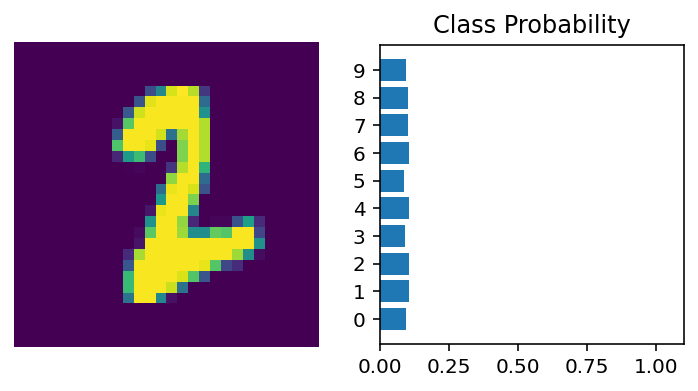

In [94]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

# Training Neural Networks

The network we built isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [95]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.2018, -0.1819],
        [ 1.1219,  1.4242]], requires_grad=True)


In [96]:
y = x**2
print(y)

tensor([[0.0407, 0.0331],
        [1.2587, 2.0283]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [97]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [98]:
z = y.mean()
print(z)

tensor(0.8402, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [99]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [100]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.1009, -0.0910],
        [ 0.5610,  0.7121]])
tensor([[-0.1009, -0.0910],
        [ 0.5610,  0.7121]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

I'll build a network with `nn.Sequential` here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [101]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [128, 64]
output_size  = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('relu2', nn.ReLU()),
          ('logits', nn.Linear(hidden_sizes[1], output_size))]))

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [103]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[-0.0048, -0.0195,  0.0354,  ..., -0.0049,  0.0040,  0.0124],
        [ 0.0267, -0.0090,  0.0188,  ..., -0.0248,  0.0200,  0.0345],
        [ 0.0197, -0.0248,  0.0212,  ...,  0.0293,  0.0318,  0.0046],
        ...,
        [-0.0118, -0.0061, -0.0197,  ...,  0.0053, -0.0177,  0.0150],
        [-0.0034, -0.0330, -0.0356,  ...,  0.0238,  0.0040,  0.0059],
        [-0.0034, -0.0231,  0.0140,  ...,  0.0171, -0.0315,  0.0183]],
       requires_grad=True)
Gradient - tensor([[-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        ...,
        [-0.0034, -0.0034, -0.0034,  ..., -0.0034, -0.0034, -0.0034],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [-0.0014, -0.0014, -0.0014,  ..., -0.0014, -0.0014, -0.0014]])


In [104]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[-0.0048, -0.0195,  0.0354,  ..., -0.0049,  0.0040,  0.0124],
        [ 0.0267, -0.0090,  0.0187,  ..., -0.0248,  0.0200,  0.0345],
        [ 0.0197, -0.0248,  0.0213,  ...,  0.0294,  0.0318,  0.0046],
        ...,
        [-0.0118, -0.0061, -0.0197,  ...,  0.0054, -0.0176,  0.0150],
        [-0.0034, -0.0330, -0.0356,  ...,  0.0238,  0.0040,  0.0059],
        [-0.0034, -0.0231,  0.0140,  ...,  0.0171, -0.0314,  0.0183]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [105]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [106]:
epochs = 3
print_every = 40

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0

Epoch: 1/3
	Iteration: 0	 Loss: 0.0580
	Iteration: 40	 Loss: 2.2854
	Iteration: 80	 Loss: 2.2580
	Iteration: 120	 Loss: 2.2361
	Iteration: 160	 Loss: 2.2065
	Iteration: 200	 Loss: 2.1784
	Iteration: 240	 Loss: 2.1469
	Iteration: 280	 Loss: 2.1200
	Iteration: 320	 Loss: 2.0792
	Iteration: 360	 Loss: 2.0288
	Iteration: 400	 Loss: 1.9875
	Iteration: 440	 Loss: 1.9360
	Iteration: 480	 Loss: 1.8877
	Iteration: 520	 Loss: 1.8110
	Iteration: 560	 Loss: 1.7591
	Iteration: 600	 Loss: 1.6997
	Iteration: 640	 Loss: 1.6496
	Iteration: 680	 Loss: 1.5570
	Iteration: 720	 Loss: 1.5056
	Iteration: 760	 Loss: 1.4091
	Iteration: 800	 Loss: 1.3749
	Iteration: 840	 Loss: 1.3046
	Iteration: 880	 Loss: 1.2652
	Iteration: 920	 Loss: 1.1705
Epoch: 2/3
	Iteration: 0	 Loss: 0.0283
	Iteration: 40	 Loss: 1.0967
	Iteration: 80	 Loss: 1.0734
	Iteration: 120	 Loss: 1.0303
	Iteration: 160	 Loss: 0.9995
	Iteration: 200	 Loss: 0.9453
	Iteration: 240	 Loss: 0.9063
	Iteration: 280	 Loss: 0.8807
	Iteration: 320	 Loss: 0.8

With the network trained, we can check out it's predictions.

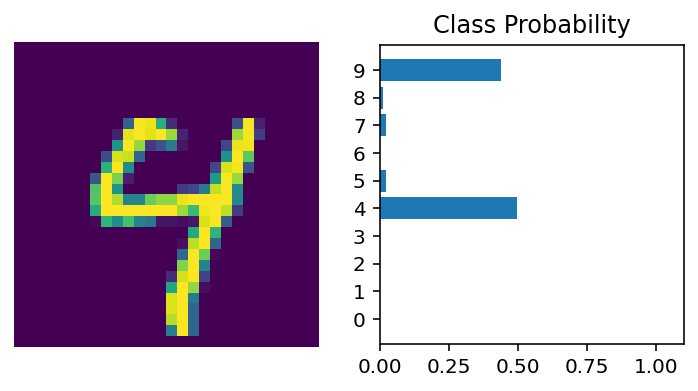

In [107]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images.

<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center" style="color:#01ff84">MNIST Clasification: Exercise</h2>
<div>

<div style="background:#222222; color:#ffffff; padding:20px">
  <h3 style="color:#01ff84; margin-top:4px">Exercise 1:</h3>
  <p>Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions.</p>
  <p>Build a network to classify the MNIST images with 3 hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer.</p>
<div>

In [248]:
## TODO: Your network here

n_features = 28*28
hidden_sizes = [400, 200, 100]
output_size = 10
neuralnet = nn.Sequential(
                            nn.Linear(n_features,hidden_sizes[0]), # 1st hidden layer
                            nn.ReLU(), 
                            nn.Linear(hidden_sizes[0], hidden_sizes[1]), # 2nd hidden layer
                            nn.ReLU(), 
                            nn.Linear(hidden_sizes[1], hidden_sizes[2]), # 3rd hidden layer
                            nn.ReLU(),
                            nn.Linear(hidden_sizes[2], output_size), # output layer
                            # nn.LogSoftmax(dim=1)                      
                            )


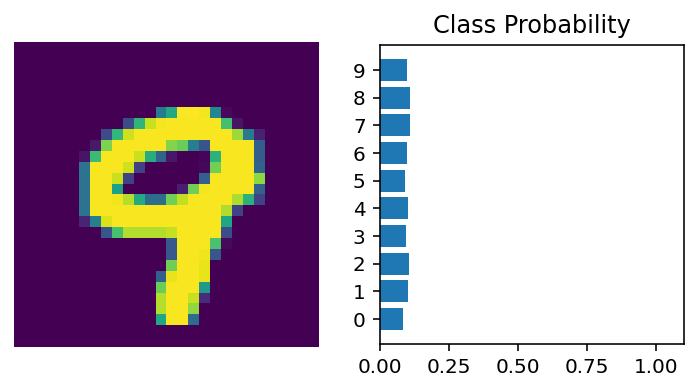

In [246]:
# Run this cell with your model to make sure it works
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = F.softmax(neuralnet.forward(images[0,:]), dim=1)
view_classify(images[0].view(1, 28, 28), ps)

  <h3 style="color:#01ff84; margin-top:4px">Exercise 2:</h3>
  <p>Train your network implementing the Pytorch training loop and <strong style="color:#01ff84">after each epoch, use the model for predicting the test (validation) MNIST data.</strong></p>
  <p>Note: If your model does not fit with the final softmax layer, you can remove this layer.</p>
  <p>Hint: <a href="https://discuss.pytorch.org/t/training-loop-checking-validation-accuracy/78399">Training loop checking validation accuracy
</a></p>
  <p>Research about <code>model.train()</code>, <code>model.eval()</code> and <code>with torch.no_grad()</code> in Pytorch.


Epoch: 1/6
	Iteration: 0	 Loss: 0.0577
	Iteration: 40	 Loss: 1.9846
	Iteration: 80	 Loss: 0.7329
	Iteration: 120	 Loss: 0.5070
	Iteration: 160	 Loss: 0.5080
	Iteration: 200	 Loss: 0.4267
	Iteration: 240	 Loss: 0.3977
	Iteration: 280	 Loss: 0.3891
	Iteration: 320	 Loss: 0.3584
	Iteration: 360	 Loss: 0.4195
	Iteration: 400	 Loss: 0.3544
	Iteration: 440	 Loss: 0.3835
	Iteration: 480	 Loss: 0.3178
	Iteration: 520	 Loss: 0.3539
	Iteration: 560	 Loss: 0.2905
	Iteration: 600	 Loss: 0.3480
	Iteration: 640	 Loss: 0.3567
	Iteration: 680	 Loss: 0.3535
	Iteration: 720	 Loss: 0.3110
	Iteration: 760	 Loss: 0.3177
	Iteration: 800	 Loss: 0.3135
	Iteration: 840	 Loss: 0.2959
	Iteration: 880	 Loss: 0.2996
	Iteration: 920	 Loss: 0.2952


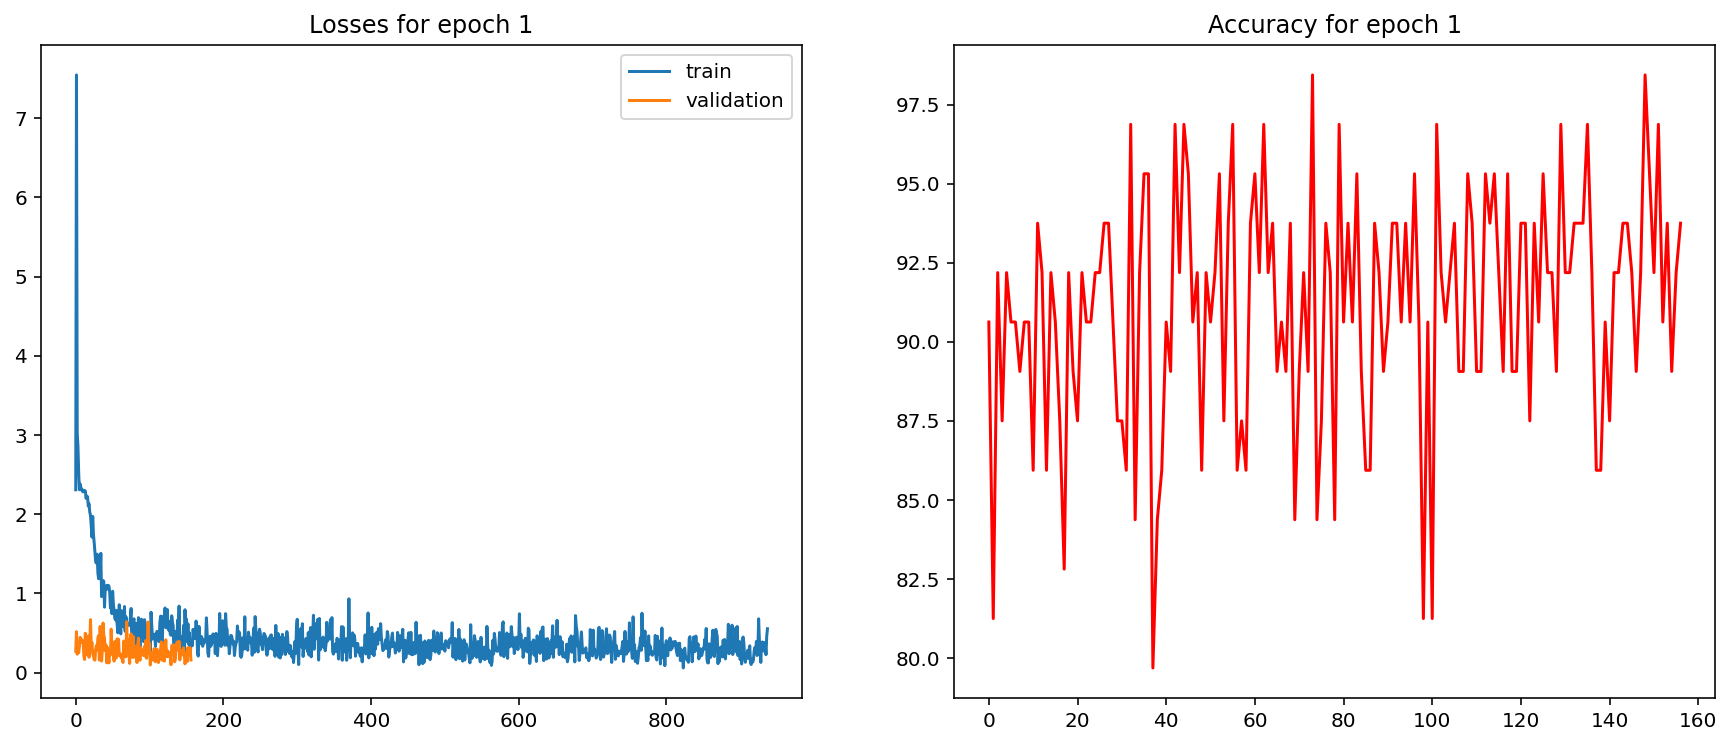

Epoch: 2/6
	Iteration: 0	 Loss: 0.0072
	Iteration: 40	 Loss: 0.3536
	Iteration: 80	 Loss: 0.2492
	Iteration: 120	 Loss: 0.3042
	Iteration: 160	 Loss: 0.2688
	Iteration: 200	 Loss: 0.2330
	Iteration: 240	 Loss: 0.2955
	Iteration: 280	 Loss: 0.2499
	Iteration: 320	 Loss: 0.2809
	Iteration: 360	 Loss: 0.2622
	Iteration: 400	 Loss: 0.2699
	Iteration: 440	 Loss: 0.2587
	Iteration: 480	 Loss: 0.2769
	Iteration: 520	 Loss: 0.2333
	Iteration: 560	 Loss: 0.2636
	Iteration: 600	 Loss: 0.2764
	Iteration: 640	 Loss: 0.2684
	Iteration: 680	 Loss: 0.2697
	Iteration: 720	 Loss: 0.2445
	Iteration: 760	 Loss: 0.2820
	Iteration: 800	 Loss: 0.3107
	Iteration: 840	 Loss: 0.2706
	Iteration: 880	 Loss: 0.2736
	Iteration: 920	 Loss: 0.2694


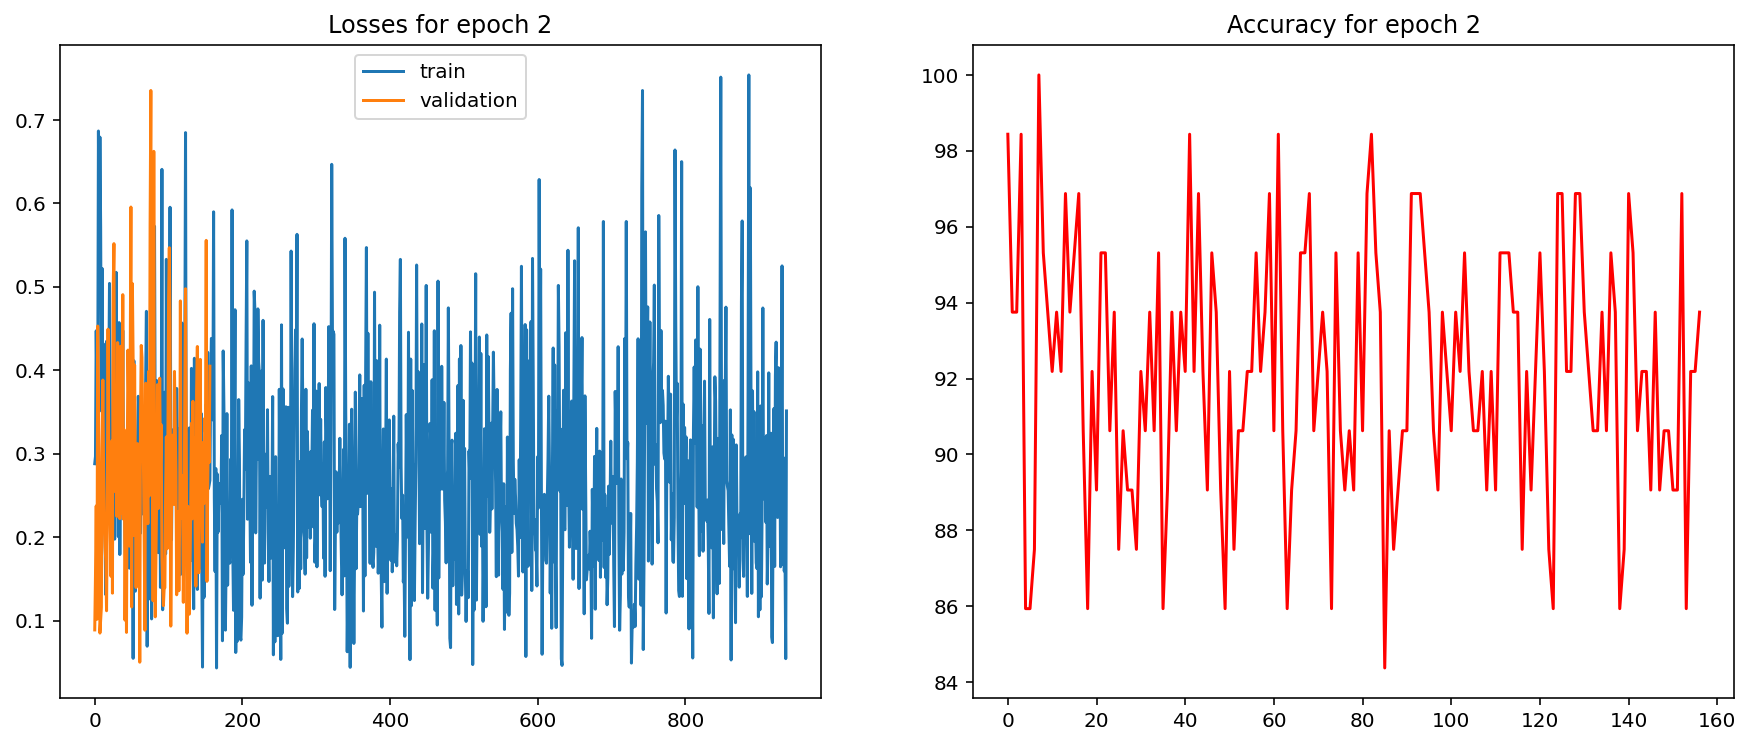

Epoch: 3/6
	Iteration: 0	 Loss: 0.0042
	Iteration: 40	 Loss: 0.2289
	Iteration: 80	 Loss: 0.2443
	Iteration: 120	 Loss: 0.2632
	Iteration: 160	 Loss: 0.2250
	Iteration: 200	 Loss: 0.2257
	Iteration: 240	 Loss: 0.2359
	Iteration: 280	 Loss: 0.2486
	Iteration: 320	 Loss: 0.2624
	Iteration: 360	 Loss: 0.2522
	Iteration: 400	 Loss: 0.2268
	Iteration: 440	 Loss: 0.2394
	Iteration: 480	 Loss: 0.2049
	Iteration: 520	 Loss: 0.2593
	Iteration: 560	 Loss: 0.2690
	Iteration: 600	 Loss: 0.2651
	Iteration: 640	 Loss: 0.2648
	Iteration: 680	 Loss: 0.2267
	Iteration: 720	 Loss: 0.2634
	Iteration: 760	 Loss: 0.2187
	Iteration: 800	 Loss: 0.2205
	Iteration: 840	 Loss: 0.2522
	Iteration: 880	 Loss: 0.2070
	Iteration: 920	 Loss: 0.2324


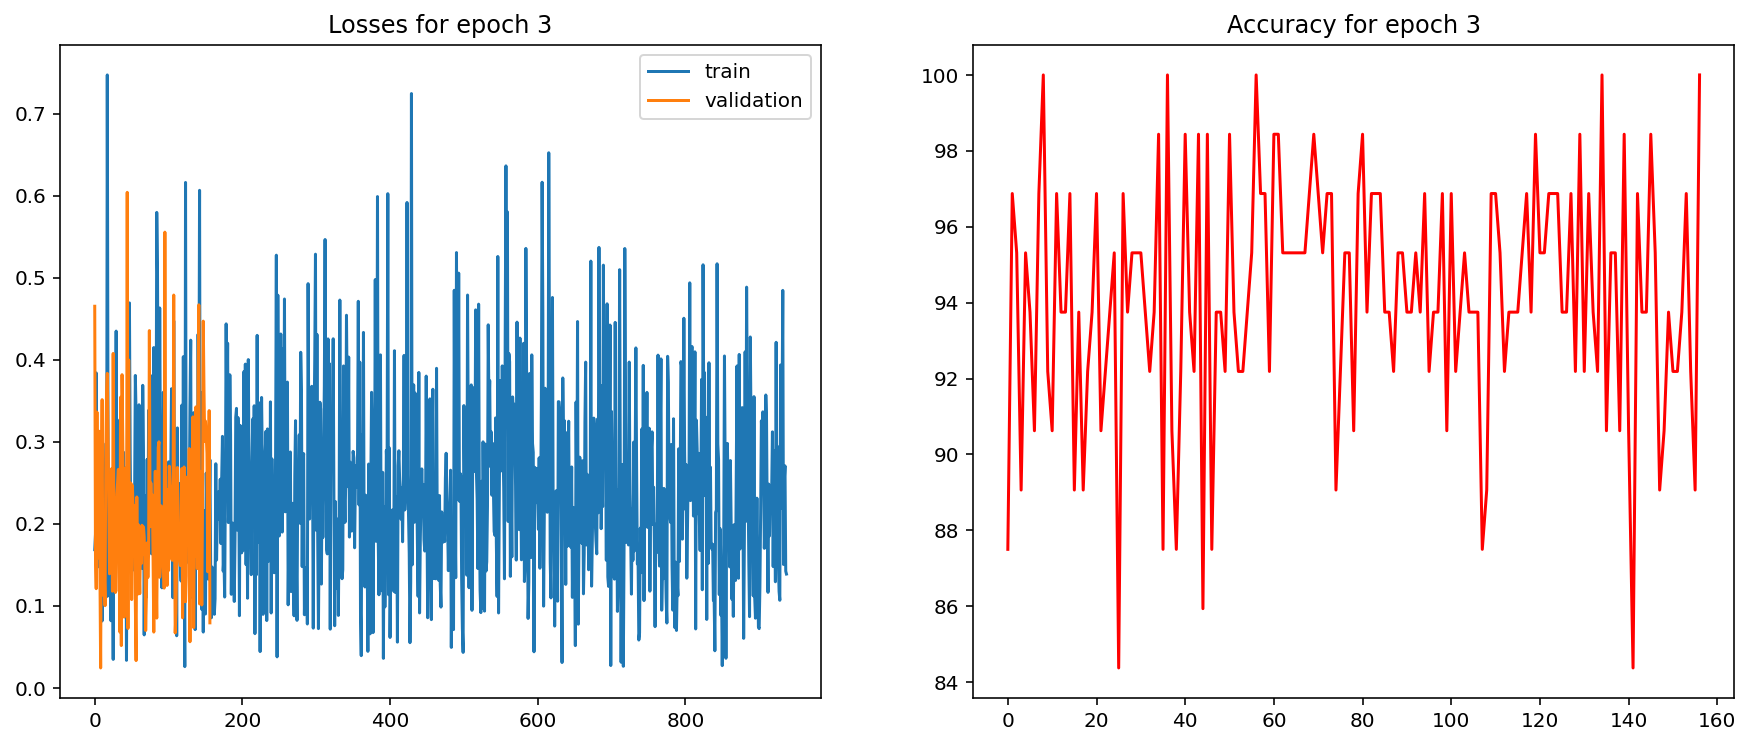

Epoch: 4/6
	Iteration: 0	 Loss: 0.0032
	Iteration: 40	 Loss: 0.1942
	Iteration: 80	 Loss: 0.2285
	Iteration: 120	 Loss: 0.2136
	Iteration: 160	 Loss: 0.1962
	Iteration: 200	 Loss: 0.2206
	Iteration: 240	 Loss: 0.2722
	Iteration: 280	 Loss: 0.2037
	Iteration: 320	 Loss: 0.2094
	Iteration: 360	 Loss: 0.2070
	Iteration: 400	 Loss: 0.2531
	Iteration: 440	 Loss: 0.2356
	Iteration: 480	 Loss: 0.2370
	Iteration: 520	 Loss: 0.2285
	Iteration: 560	 Loss: 0.2749
	Iteration: 600	 Loss: 0.2300
	Iteration: 640	 Loss: 0.2464
	Iteration: 680	 Loss: 0.2272
	Iteration: 720	 Loss: 0.2212
	Iteration: 760	 Loss: 0.2124
	Iteration: 800	 Loss: 0.2389
	Iteration: 840	 Loss: 0.2389
	Iteration: 880	 Loss: 0.2678
	Iteration: 920	 Loss: 0.2249


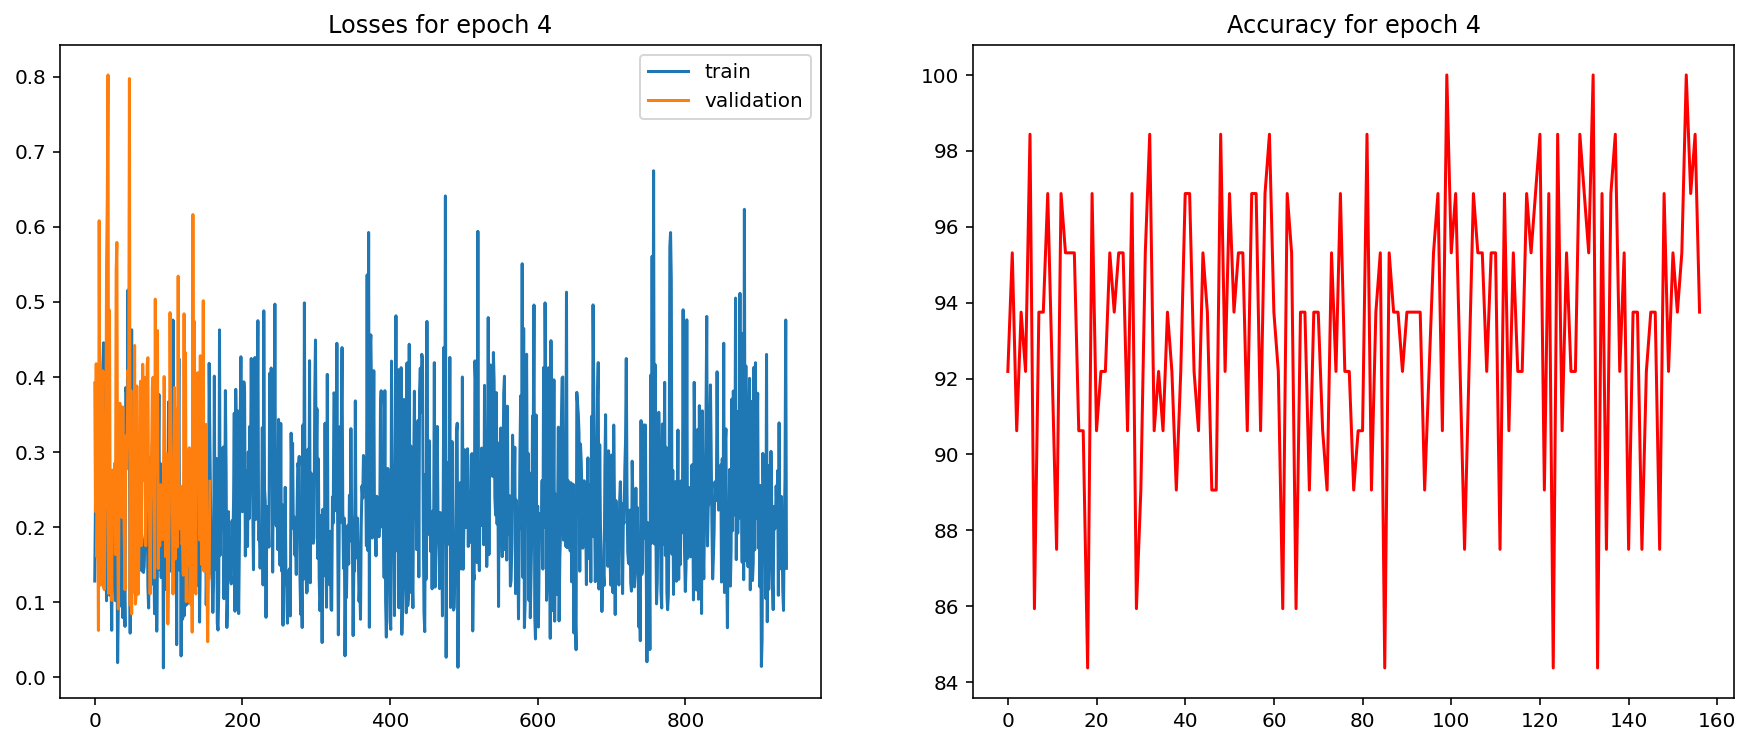

Epoch: 5/6
	Iteration: 0	 Loss: 0.0053
	Iteration: 40	 Loss: 0.2337
	Iteration: 80	 Loss: 0.1751
	Iteration: 120	 Loss: 0.2156
	Iteration: 160	 Loss: 0.2486
	Iteration: 200	 Loss: 0.1786
	Iteration: 240	 Loss: 0.2254
	Iteration: 280	 Loss: 0.2638
	Iteration: 320	 Loss: 0.2576
	Iteration: 360	 Loss: 0.2253
	Iteration: 400	 Loss: 0.2557
	Iteration: 440	 Loss: 0.2342
	Iteration: 480	 Loss: 0.2533
	Iteration: 520	 Loss: 0.2105
	Iteration: 560	 Loss: 0.2258
	Iteration: 600	 Loss: 0.2240
	Iteration: 640	 Loss: 0.2105
	Iteration: 680	 Loss: 0.2273
	Iteration: 720	 Loss: 0.1847
	Iteration: 760	 Loss: 0.2122
	Iteration: 800	 Loss: 0.2435
	Iteration: 840	 Loss: 0.2189
	Iteration: 880	 Loss: 0.2264
	Iteration: 920	 Loss: 0.2268


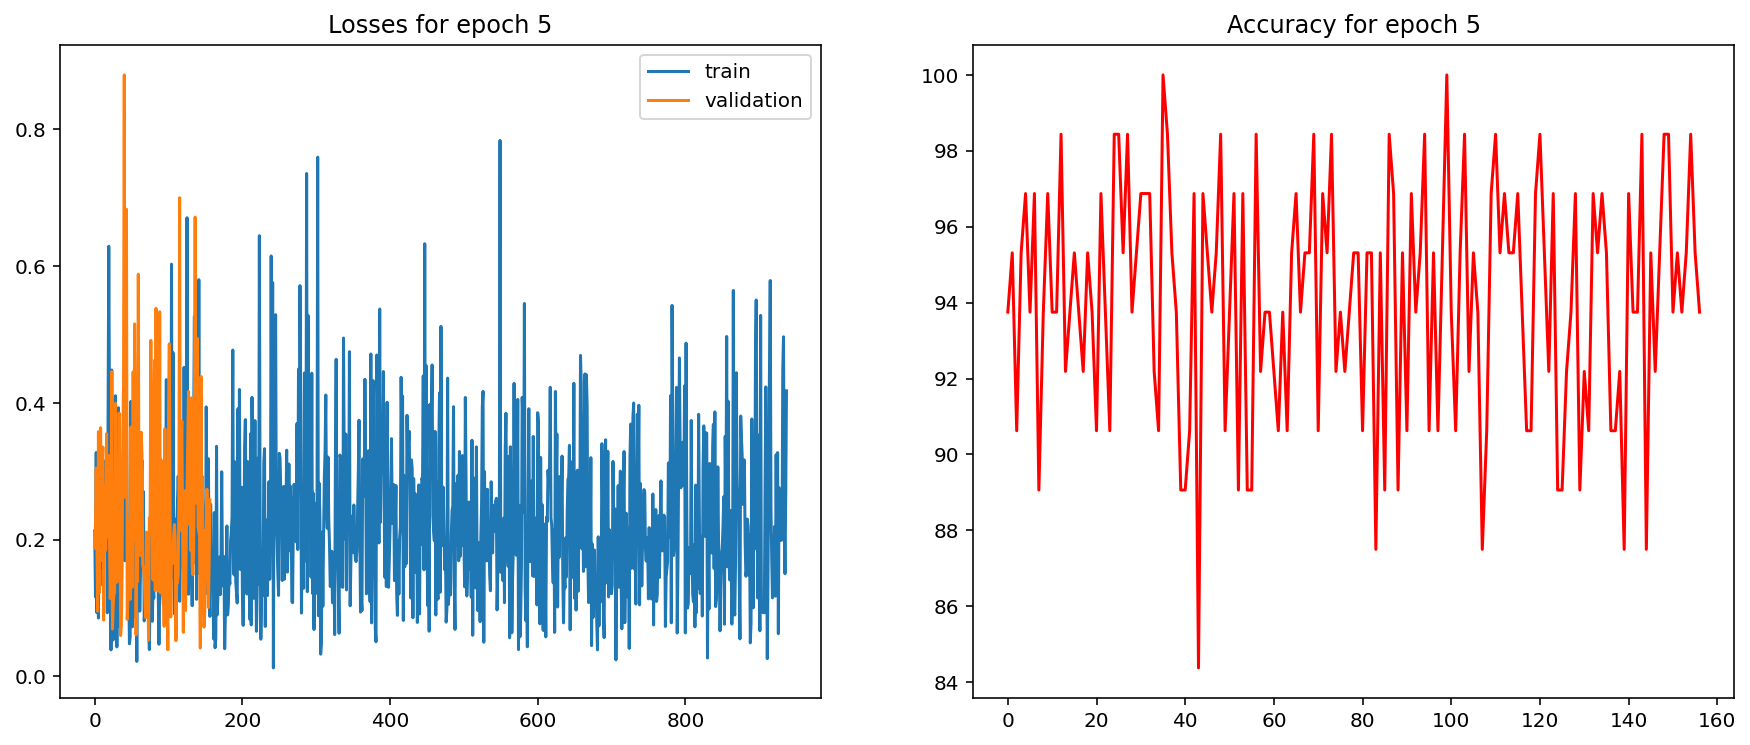

Epoch: 6/6
	Iteration: 0	 Loss: 0.0096
	Iteration: 40	 Loss: 0.2031
	Iteration: 80	 Loss: 0.1949
	Iteration: 120	 Loss: 0.2042
	Iteration: 160	 Loss: 0.2305
	Iteration: 200	 Loss: 0.2051
	Iteration: 240	 Loss: 0.2858
	Iteration: 280	 Loss: 0.2617
	Iteration: 320	 Loss: 0.2723
	Iteration: 360	 Loss: 0.2284
	Iteration: 400	 Loss: 0.2205
	Iteration: 440	 Loss: 0.2562
	Iteration: 480	 Loss: 0.2059
	Iteration: 520	 Loss: 0.1877
	Iteration: 560	 Loss: 0.1848
	Iteration: 600	 Loss: 0.2159
	Iteration: 640	 Loss: 0.2120
	Iteration: 680	 Loss: 0.2161
	Iteration: 720	 Loss: 0.1814
	Iteration: 760	 Loss: 0.2100
	Iteration: 800	 Loss: 0.1905
	Iteration: 840	 Loss: 0.1933
	Iteration: 880	 Loss: 0.2417
	Iteration: 920	 Loss: 0.1968


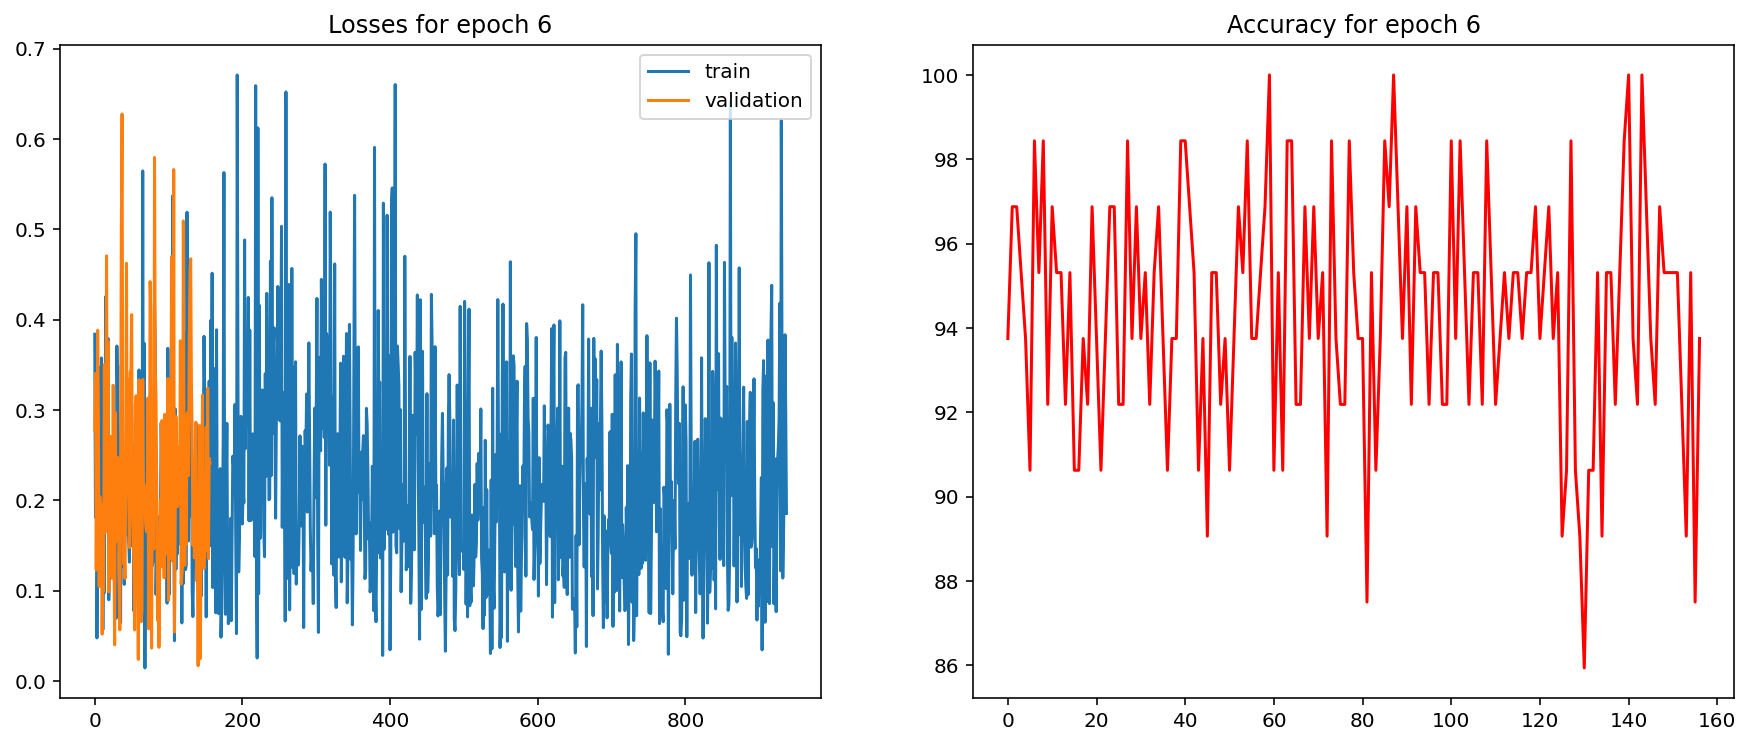

In [249]:
## TODO: Your training loop here
learning_rate = 0.01
optimizer = optim.Adam(neuralnet.parameters(), lr= learning_rate)
epochs = 6
print_every = 40
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    val_losses = []
    accuracies = []
    train_losses = []
    running_loss = 0
    print(f"Epoch: {epoch+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # 2D Tensor
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = neuralnet.forward(images)
        loss = criterion(output, labels)
        train_losses.append(loss.detach().item()) 
        loss.backward()                  
        optimizer.step()                
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0


    # validation
    neuralnet.eval()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(testloader):
            # resize to 2D tensor
            images.resize_(images.size()[0], 784)

            # predictions
            scores = neuralnet(images)
            preds = scores.argmax(dim=1)

            # accuracy
            acc = (preds == labels).sum() / len(labels) * 100
            accuracies.append(acc)

            # validation loss
            val_loss = criterion(scores, labels)
            val_losses.append(val_loss)



    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)   
    plt.plot(train_losses, label = 'train')
    plt.plot(val_losses, label = 'validation')
    plt.legend()
    plt.title(f'Losses for epoch {epoch + 1}')

    plt.subplot(1, 2, 2)
    plt.plot(list(range(len(testloader))), accuracies, c = 'red', label = 'accuracy')
    plt.title(f'Accuracy for epoch {epoch + 1}')

    plt.show()
    

    neuralnet.train()


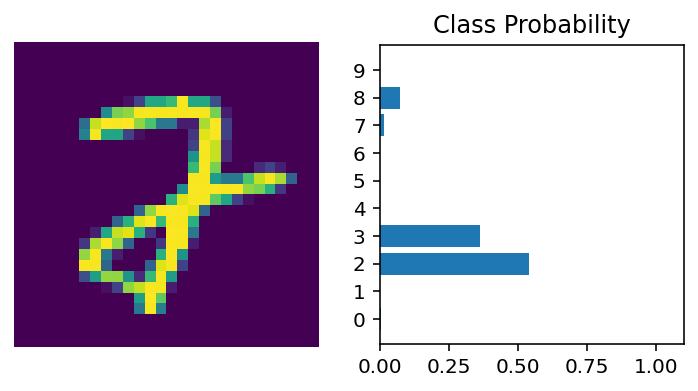

In [210]:
# Run this cell with your model to make sure it works and predicts well for the validation data
images, labels = next(iter(testloader))
images.resize_(images.shape[0], 1, 784)
ps = F.softmax(neuralnet.forward(images[0,:]), dim=1)
view_classify(images[0].view(1, 28, 28), ps)

  <h3 style="color:#01ff84; margin-top:4px">Exercise 3:</h3>
  <p>Write the code for adding <strong style="color:#01ff84">Early Stopping with patience = 2</strong> to the training loop from scratch.</p>
  <p><strong style="color:#01ff84">Hint:</strong> Monitor the Validation loss every epoch, and if in 2 epochs, the validation loss does not improve, stop the training loop with <code>break</code>.</p>

In [ ]:
## TODO: Your training loop here